## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

## Import Tables

In [2]:
# Doug's Path
diagnoses_icd = pd.read_csv('../data/mimic-iv-0.4/hosp/diagnoses_icd.csv.gz', compression='gzip')
d_icd_diagnoses = pd.read_csv('../data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv.gz', compression='gzip')
admissions = pd.read_csv('../data/mimic-iv-0.4/core/admissions.csv.gz', compression='gzip')
patients =  pd.read_csv('../data/mimic-iv-0.4/core/patients.csv.gz', compression='gzip')
d_labitems = pd.read_csv('../data/mimic-iv-0.4/hosp/d_labitems.csv.gz', compression='gzip')

# # Stephen's Path
# path = "D:\\Bootcamp\\MIMIC IV\\"
# admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
# patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# diagnoses_icd = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
# d_icd_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
# d_labitems = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

## Pull codes related to target Diagnosis

In [3]:
# Congestive Heart Failure
pos_codes = list(map(str, d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('congestive')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('heart'))]['icd_code']))

# kidney_list = list(d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('kidney')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('failure'))]['icd_code'])
# pd.DataFrame(diagnoses_icd[diagnoses_icd['icd_code'].isin(kidney_list)].icd_code.value_counts()).reset_index().head(20).merge(d_icd_diagnoses, left_index = True, left_on = "index", right_on = 'icd_code', how = 'left')

# ICD Codes we care about for AKI
# 5849, N179, 5845, N170
# pos_codes = ['5849   ', 'N179   ', '5845   ', 'N170   ']


## Start filtering down to only records where Diagnosis is Positive

In [4]:
diagnoses_icd_pos = diagnoses_icd[diagnoses_icd['icd_code'].isin(pos_codes)]


In [5]:
diagnoses_icd_pos.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
886,16569548,24870770,12,4280,9
1050,18460230,25771608,2,4280,9
2342,19661870,22135027,3,4280,9
2683,18932584,23973570,10,4280,9
2961,16723797,28913496,30,4280,9


In [6]:
admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,NaN,UNKNOWN,NaN,NaN,0
1,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,NaN,OTHER,NaN,NaN,0
2,14495017,22484010,2175-01-28 15:41:00,2175-01-29 16:00:00,NaN,DIRECT EMER.,PHYSICIAN REFERRAL,HOME,Other,?,NaN,WHITE,NaN,NaN,0
3,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME,Other,?,MARRIED,WHITE,NaN,NaN,0
4,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,WHITE,2131-01-26 22:19:00,2131-01-27 05:39:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524515,17892964,20786062,2180-09-17 00:00:00,2180-09-18 13:37:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,ENGLISH,SINGLE,WHITE,NaN,NaN,0
524516,17137572,20943099,2147-08-01 17:41:00,2147-08-02 17:30:00,NaN,EW EMER.,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,DIVORCED,HISPANIC/LATINO,2147-07-31 23:55:00,2147-08-01 19:37:00,0
524517,19389857,23176714,2189-03-01 00:58:00,2189-03-02 15:22:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0
524518,12298845,22347500,2138-05-31 00:00:00,2138-06-04 16:50:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaN,NaN,0


In [8]:
admissions = admissions[admissions.ethnicity=='HISPANIC/LATINO']
admissions.ethnicity.value_counts()

HISPANIC/LATINO    29887
Name: ethnicity, dtype: int64

## Generate new Admissions table with hospital stay duration and Positive Diagnosis Flag

In [9]:

admissions_pos = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'ethnicity']]

admissions_pos['pos_subj'] = np.where(admissions_pos.subject_id.isin(diagnoses_icd_pos.subject_id), 1, 0)
admissions_pos['pos_adm'] = np.where(admissions_pos.hadm_id.isin(diagnoses_icd_pos.hadm_id), 1, 0)
admissions_pos['time_spent'] = pd.to_datetime(admissions_pos['dischtime']) - pd.to_datetime(admissions_pos['admittime'])

admissions.edregtime = pd.to_datetime(admissions.edregtime)
admissions.edouttime = pd.to_datetime(admissions.edouttime)
admissions['ed_length']=np.where(admissions.edregtime.isna(),0,(admissions.edouttime-admissions.edregtime)/pd.offsets.Hour(1))

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to b

In [10]:
admissions_pos.head(10)

,subject_id,hadm_id,admittime,dischtime,ethnicity,pos_subj,pos_adm,time_spent
40,12278031,22876020,2182-11-20 12:56:00,2182-11-27 14:15:00,HISPANIC/LATINO,0,0,7 days 01:19:00
91,13715714,21929349,2116-10-15 23:06:00,2116-10-19 13:15:00,HISPANIC/LATINO,0,0,3 days 14:09:00
92,14556479,27885883,2145-12-29 00:30:00,2145-12-30 17:50:00,HISPANIC/LATINO,0,0,1 days 17:20:00
123,16176338,25385530,2143-06-05 00:24:00,2143-06-07 15:06:00,HISPANIC/LATINO,0,0,2 days 14:42:00
128,14426216,26722006,2186-01-01 03:13:00,2186-01-03 12:01:00,HISPANIC/LATINO,0,0,2 days 08:48:00
213,18825388,20238829,2140-06-15 18:45:00,2140-06-18 15:49:00,HISPANIC/LATINO,0,0,2 days 21:04:00
278,19294011,23491270,2151-12-05 12:34:00,2151-12-07 12:42:00,HISPANIC/LATINO,0,0,2 days 00:08:00
279,18215576,25588584,2118-01-23 16:38:00,2118-01-27 11:55:00,HISPANIC/LATINO,0,0,3 days 19:17:00
340,18732983,25965490,2164-09-11 07:40:00,2164-09-11 11:57:00,HISPANIC/LATINO,0,0,0 days 04:17:00
363,14489764,25009189,2183-08-10 01:02:00,2183-08-11 17:15:00,HISPANIC/LATINO,0,0,1 days 16:13:00


In [11]:
# admissions_pos=admissions_pos.merge(patients, on='subject_id')
# admissions_pos

In [12]:
# admissions_pos = admissions_pos[admissions_pos.gender=='F']
# admissions_pos.gender.value_counts()

In [17]:
admissions_pos

,subject_id,hadm_id,admittime,dischtime,ethnicity,pos_subj,pos_adm,time_spent
40,12278031,22876020,2182-11-20 12:56:00,2182-11-27 14:15:00,HISPANIC/LATINO,0,0,7 days 01:19:00
91,13715714,21929349,2116-10-15 23:06:00,2116-10-19 13:15:00,HISPANIC/LATINO,0,0,3 days 14:09:00
92,14556479,27885883,2145-12-29 00:30:00,2145-12-30 17:50:00,HISPANIC/LATINO,0,0,1 days 17:20:00
123,16176338,25385530,2143-06-05 00:24:00,2143-06-07 15:06:00,HISPANIC/LATINO,0,0,2 days 14:42:00
128,14426216,26722006,2186-01-01 03:13:00,2186-01-03 12:01:00,HISPANIC/LATINO,0,0,2 days 08:48:00
...,...,...,...,...,...,...,...,...
524328,13029568,25230272,2195-03-21 13:21:00,2195-03-22 16:43:00,HISPANIC/LATINO,1,0,1 days 03:22:00
524333,15743696,26040182,2134-06-24 07:35:00,2134-06-28 13:21:00,HISPANIC/LATINO,0,0,4 days 05:46:00
524375,15864273,27682766,2144-12-31 14:20:00,2145-01-06 13:45:00,HISPANIC/LATINO,0,0,5 days 23:25:00
524451,15346117,20604717,2195-01-21 20:37:00,2195-01-24 16:53:00,HISPANIC/LATINO,1,0,2 days 20:16:00


## Sample Target Patients for Modeling

In [18]:
n_samples = 15000

target_sample = admissions_pos[['subject_id', 'pos_subj']].drop_duplicates()

# target_sample = resample(target_sample, n_samples = n_samples, replace = False, stratify = target_sample.pos_subj, random_state = 0)


In [19]:
target_sample

,subject_id,pos_subj
40,12278031,0
91,13715714,0
92,14556479,0
123,16176338,0
128,14426216,0
...,...,...
523973,17724027,0
523975,18508676,0
524227,15413853,0
524333,15743696,0


In [20]:
# identify first pos visit for NON-pos patients
sample_non = target_sample[target_sample.pos_subj==0]
admissions_non = admissions[admissions.subject_id.isin(sample_non.subject_id)]
admissions_non['admittime'] = pd.to_datetime(admissions_non.admittime)
first_non = admissions_non.loc[admissions_non.groupby('subject_id').admittime.idxmin()]
# sanity checks
print(first_non.shape)                 # number of rows
print(first_non.subject_id.nunique())  # matches number of patients
print(first_non.hadm_id.nunique())     # matches number of visits

# pull out hospital visits for target non-pos samples
sample_non = sample_non.merge(first_non, how='inner', on='subject_id')
sample_non = sample_non[['subject_id', 'hadm_id', 'pos_subj']]
sample_non = sample_non.rename({'pos_subj':'pos'}, axis=1)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(13062, 16)
13062
13062


In [21]:
# identify first pos visit for all pos patients
sample_pos = target_sample[target_sample.pos_subj==1]
first_pos = admissions_pos[admissions_pos.subject_id.isin(sample_pos.subject_id)]
first_pos['admittime'] = pd.to_datetime(first_pos.admittime)
first_pos = first_pos.loc[first_pos[first_pos.pos_adm==1].groupby('subject_id').admittime.idxmin()]
first_pos = first_pos[['subject_id', 'hadm_id', 'pos_adm']]
# sanity checks
print(np.mean(first_pos.pos_adm))   # make sure everyone has pos
print(first_pos.shape)                 # make sure number of rows...
print(first_pos.subject_id.nunique())  # ...matches number of patients
print(first_pos.hadm_id.nunique())     # ...matches number of visits

# pull out hospital visits for target pos samples
sample_pos = sample_pos.merge(first_pos, how='inner', on='subject_id')
sample_pos = sample_pos[['subject_id', 'hadm_id', 'pos_adm']]
sample_pos = sample_pos.rename({'pos_adm':'pos'}, axis=1)

1.0
(707, 3)
707
707


/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
# merge back together
admissions_sample = pd.concat([sample_pos, sample_non])
admissions_sample = admissions_sample.reset_index(drop=True)
print(admissions_sample.shape)                  # sanity check
print(admissions_sample.subject_id.nunique())   # sanity check

(13769, 3)
13769


In [23]:
# merge features from other tables
admissions_sample = admissions_sample.merge(admissions[['hadm_id', 'ethnicity','ed_length','insurance']], how='left', on='hadm_id')
admissions_sample = admissions_sample.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on='subject_id')

# basic data cleaning
admissions_sample.loc[admissions_sample.ethnicity=='UNABLE TO OBTAIN', 'ethnicity'] = 'UNKNOWN'  # combine unkown
admissions_sample = admissions_sample.rename(columns={'anchor_age':'age'})
admissions_sample = admissions_sample[admissions_sample.age > 0]   # remove children

Text(0.5, 1.0, 'Age Distribution')

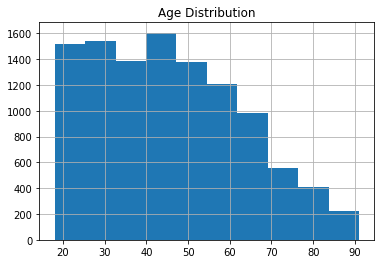

In [24]:
admissions_sample.age.hist()
plt.title('Age Distribution')

Text(0.5, 1.0, 'Gender Distribution')

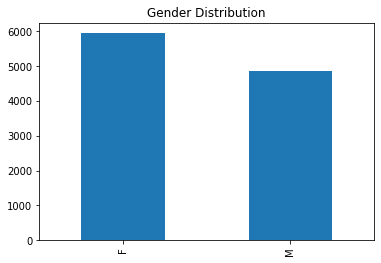

In [25]:
admissions_sample.gender.value_counts().plot(kind='bar')
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Ethnicity Distribution')

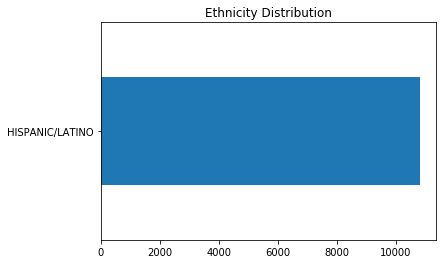

In [26]:
admissions_sample.ethnicity.value_counts().plot(kind='barh')
plt.title('Ethnicity Distribution')

In [27]:
print('Number of unique Patients: ', target_sample.subject_id.nunique())
print('\nSample Breakdown:')
print(target_sample.pos_subj.value_counts())

Number of unique Patients:  13800

Sample Breakdown:
0    13062
1      738
Name: pos_subj, dtype: int64


Generate pickle file so we all work on the exact same data

In [28]:
admissions_sample.to_pickle('../data/admissions_sample_latino.pkl')

In [29]:
# admissions_sample = pd.read_pickle("admissions_sample.pkl")

In [30]:
admissions_sample

,subject_id,hadm_id,pos,ethnicity,ed_length,insurance,gender,age
0,10730160,26402903,1,HISPANIC/LATINO,7.033333,Other,M,32
1,11340246,29722576,1,HISPANIC/LATINO,0.000000,Medicare,F,58
2,13398773,21636338,1,HISPANIC/LATINO,4.500000,Medicare,M,66
3,10900387,26613293,1,HISPANIC/LATINO,7.383333,Medicaid,M,41
4,19575521,28822754,1,HISPANIC/LATINO,0.000000,Medicare,F,59
...,...,...,...,...,...,...,...,...
13764,17724027,23940145,0,HISPANIC/LATINO,4.666667,Medicare,F,70
13765,18508676,25937678,0,HISPANIC/LATINO,2.150000,Other,F,54
13766,15413853,21395195,0,HISPANIC/LATINO,7.700000,Medicare,F,86
13767,15743696,26040182,0,HISPANIC/LATINO,0.000000,Other,F,30
